<a href="https://colab.research.google.com/github/albertometelli/rl-phd-2020/01_intro_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Gym Environment

This notebook is inspired to the Stable Baselines3 tutorial available at [https://github.com/araffin/rl-tutorial-jnrr19](https://github.com/araffin/rl-tutorial-jnrr19).


## Introduction

In this notebook, we will learn how to build a customized environment with **Open AI Gym**.

### Links

Open AI Gym Github: [https://github.com/openai/gym](https://github.com/openai/gym)

Open AI Gym Documentation: [https://www.gymlibrary.ml](https://www.gymlibrary.ml)

Stable Baselines 3 Github:[https://github.com/DLR-RM/stable-baselines3](https://github.com/DLR-RM/stable-baselines3)

Stable Baseline 3 Documentation: [https://stable-baselines3.readthedocs.io/en/master/](https://stable-baselines3.readthedocs.io/en/master/)

## Install Dependencies and Stable Baselines3 Using Pip

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

In [2]:
import stable_baselines3
stable_baselines3.__version__

'1.4.0'

## Evaluation

A helper function to evaluate policies.

In [3]:
def evaluate(env, policy, gamma=1., num_episodes=100):
    """
    Evaluate a RL agent
    :param env: (Env object) the Gym environment
    :param policy: (BasePolicy object) the policy in stable_baselines3
    :param gamma: (float) the discount factor
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    discounter = 1.
    all_episode_rewards = []
    for i in range(num_episodes): # iterate over the episodes
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done: # iterate over the steps until termination
            action, _ = policy.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward * discounter) # compute discounted reward
            discounter *= gamma

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)
    print("Mean reward:", mean_episode_reward, 
          "Std reward:", std_episode_reward,
          "Num episodes:", num_episodes)

    return mean_episode_reward, std_episode_reward

## Plotting

A helper function to plot the learning curves.

In [4]:
import matplotlib.pyplot as plt


def plot_results(results):
    plt.figure()
    
    for k in results.keys():
        data = np.load(results[k] + '/evaluations.npz')
        ts = data['timesteps']
        res = data['results']
        _mean, _std = res.mean(axis=1), res.std(axis=1)

        plt.plot(ts, _mean, label=k)
        plt.fill_between(ts, _mean-_std, _mean+_std, alpha=.2)
        
    plt.xlabel('Timesteps')
    plt.ylabel('Average return')
    plt.legend(loc='lower right')
    
    plt.show()

## The Dam Environment

The `Dam` environment models a lake water reservoir where the objective is to learn a per-day water **release** policy that meets a given **demand** while keeping the water level below a **flooding** threshold. The reservoir dynamics is governed by the mass-conservation equation:

$$
x_{t+1} = x_t + i_t - a_t \qquad \text{with} \qquad t \in \{0,\dots,359\},
$$

where $x_t$ is the storage volume of the water reservoir at the beginning of day $t$, $i_t$ is the net inflow volume during day $t$, and $a_{t}$ is the release volume during day $t$. The state of the environment is represented by the pair $s_t=(x_t,i_{t-1})^\mathtt{T}$. The inflow $i_t$ is a memoryless cyclostationary stochstic process, governed by the equation:

$$
i_t = \overline{i}_t + \epsilon_t \qquad \text{where} \qquad \epsilon_t \sim \mathcal{N}(0,\sigma^2_i=2.0) \qquad \text{and} \qquad  \overline{i}_t = 6 + 8 \begin{cases}
                         3 \sin\left( \frac{3 \pi t}{359} \right)   & \text{if } 0 \le t < 120 \\
                         0.25 \sin\left( \frac{3 \pi t}{359} \right)  & \text{if } 120 \le t < 240 \\
                         0.5 \sin\left( \frac{3 \pi t}{359} \right)               & \text{otherwise}
                                    \end{cases}
$$

The water reservoir is supposed to have capacity of $X_{\max} = 500\, Mm^3$, minimum storage of $X_{\min}=50\, Mm^3$. A **flooding** occurs when the storage volume is above $X_{\text{flood}}=300\, Mm^3$. Thus, if we perform actions that if executed violate these constraint, they have to be clipped. The per-day **demand** is $A_{\text{demand}} = 10 Mm^3$. The reward function penalizes floodings and demands that are not satisfied:

$$
r(s,a) = -\alpha \max\{0, x_t - X_{\text{flood}}\} - \beta \max\{0, A_{\text{demand}} - a_t\}^2,
$$

where $\alpha=\beta=0.5$.

**References**

Castelletti, A., Stefano Galelli, Marcello Restelli, and Rodolfo Soncini‐Sessa. "Tree‐based reinforcement learning for optimal water reservoir operation." Water Resources Research 46, no. 9 (2010).


Parisi, Simone, Matteo Pirotta, Nicola Smacchia, Luca Bascetta, and Marcello Restelli. "Policy gradient approaches for multi-objective sequential decision making." In 2014 International Joint Conference on Neural Networks (IJCNN), pp. 2323-2330. IEEE, 2014.


Tirinzoni, Andrea, Andrea Sessa, Matteo Pirotta, and Marcello Restelli. "Importance weighted transfer of samples in reinforcement learning." In International Conference on Machine Learning, pp. 4936-4945. PMLR, 2018.

In [5]:
import gym
import numpy as np
from gym.spaces import Box

class Dam(gym.Env):
    """
    The Dam problem.
    
    """

    def __init__(self, alpha = 0.5, beta = 0.5):
        super(Dam, self).__init__()
        
        self.DEMAND = 10.0  # Water demand -> At least DEMAND/day must be supplied or a cost is incurred
        self.FLOODING = 300.0  # Flooding threshold -> No more than FLOODING can be stored or a cost is incurred
        self.MIN_STORAGE = 50.0 # Minimum storage capacity -> At most max{S - MIN_STORAGE, 0} must be released
        self.MAX_STORAGE = 500.0  # Maximum storage capacity -> At least max{S - MAX_STORAGE, 0} must be released
        self.INFLOW_STD = 2.0 # Random inflow std
        self.MAX_INFLOW = 30.0
        
        assert alpha + beta == 1.0 # Check correctness
        self.alpha = alpha
        self.beta = beta
        
        self.action_space = Box(low=np.array([0]),
                                high=np.array([self.MAX_STORAGE]),
                                dtype=np.float32)
        
        self.observation_space = Box(low=np.array([0, 0]),
                                     high=np.array([self.MAX_STORAGE, self.MAX_INFLOW]),
                                     dtype=np.float32)

                                                           
    def _inflow(self, day):
        if day < 120:
            inflow_mean = 3 * np.sin(day * 3 * np.pi / 359)
        elif day < 240:
            inflow_mean = 0.5 * np.sin(day * 3 * np.pi / 359)
        else:
            inflow_mean = 0.25 * np.sin(day * 3 * np.pi / 359)
        
        return 6 + 8 * inflow_mean
                                                           

    def reset(self):
        
        self.day = np.random.randint(0, 360)
        self.inflow = self._inflow(self.day)
        self.storage = np.random.uniform(self.MIN_STORAGE, self.MAX_STORAGE)
                                                           
        return np.array([self.storage, self.inflow]).astype(np.float32)

                                                           
    def step(self, action):
        
        action = float(action)
        
        # Bound the action
        actionLB = max(self.storage - self.MAX_STORAGE, 0.0)
        actionUB = max(self.storage - self.MIN_STORAGE, 0.0)
        bounded_action = min(max(action, actionLB), actionUB)
                                                           
        # Transition dynamics
        action = bounded_action
        nextinflow = self._inflow(self.day) + np.random.randn() * self.INFLOW_STD
        nextstorage = max(self.storage + nextinflow - action, 0.0)

        # Cost due to the excess level wrt the flooding threshold
        reward_flooding = -max(self.storage - self.FLOODING, 0.0) / 4

        # Deficit in the water supply wrt the water demand
        reward_demand = -max(self.DEMAND - action, 0.0) ** 2
        
        # The final reward is a weighted average of the two costs
        reward = self.alpha * reward_flooding + self.beta * reward_demand

        # Get next day
        nextday = self.day + 1 if self.day < 360 else 1
                                                           
        self.storage = nextstorage
        self.inflow = nextinflow
        self.day = nextday

        return np.array([self.storage, self.inflow]).astype(np.float32), reward, False, {}

To be able to instance the environment with `gym.make`, we need to register the environment

In [6]:
from gym.envs.registration import register


register(
    id="Dam-v1",
    entry_point="__main__:Dam",
    max_episode_steps=500,
    reward_threshold=0,
)

### Validate the environment

Stable Baselines3 provides a [helper](https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html) to check that our environment complies with the Gym interface.

In [7]:
from stable_baselines3.common.env_checker import check_env

env = Dam()

# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

/usr/local/lib/python3.8/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/alberto/.local/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Let us have a look to the inflow profile as a function of the day.

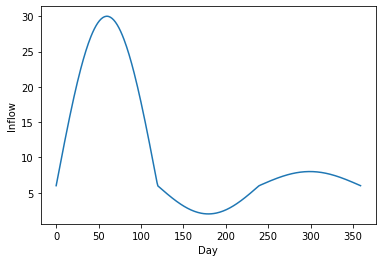

In [8]:
import matplotlib.pyplot as plt


days = np.arange(0, 360)
inflow = [env._inflow(d) for d in days]

plt.plot(days, inflow)
plt.xlabel('Day')
plt.ylabel('Inflow')
plt.show()

## Evaluate some simple Policies

* **No-release policy**: a policy that releases the minimum allowed amount of water

$$
\pi(s) = 0
$$


* **All-release policy**: a policy that releases the maximum allowed amount of water

$$
\pi(s) = +\infty
$$


* **Zero-mean Gaussian policy**: a policy that selects the action sampled from a Gaussian policy with zero mean and variance $\sigma^2=1$

$$
\pi(a|s) = \mathcal{N}(0,\sigma^2)
$$

In [9]:
class NoReleasePolicy():
    
    def predict(self, obs):
        return 0, obs


class AllReleasePolicy():
    
    def predict(self, obs):
        return np.inf, obs
    

class ZeroMeanGaussianPolicy():
    
    def predict(self, obs):
        return np.random.randn(), obs

In [10]:
env = gym.make("Dam-v1")

no_release_policy = NoReleasePolicy()

all_release_policy = AllReleasePolicy()

gauss_policy = ZeroMeanGaussianPolicy()


no_release_mean, no_release_std = evaluate(env, no_release_policy)
all_release_mean, all_release_std = evaluate(env, all_release_policy)
gauss_policy_mean, gauss_policy_std = evaluate(env, gauss_policy)

/usr/local/lib/python3.8/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Mean reward: -18882.703070834657 Std reward: 90.95518948485874 Num episodes: 100
Mean reward: -4984.202620733882 Std reward: 98.52234358579692 Num episodes: 100
Mean reward: -18742.816175026983 Std reward: 80.85152357721691 Num episodes: 100


## Train PPO, DDPG, and SAC

We now train three algorithms suitable for environments with continuous actions: [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html), [Deep Deterministic Policy Gradient](https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html), and [Soft Actor Critic](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html).

In [11]:
from stable_baselines3 import PPO, DDPG, SAC


# Separate evaluation env
eval_env = gym.make('Dam-v1')

ppo = PPO("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[64, 64]))
ddpg = DDPG("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[64, 64]))
sac = SAC("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[64, 64]))

print('PPO')
ppo.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/dam/ppo', eval_freq=2048, log_interval=4)

print('DDPG')
ddpg.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/dam/ddpg', eval_freq=2048, log_interval=4)

print('SAC')
sac.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/dam/sac', eval_freq=2048, log_interval=4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=2048, episode_reward=-18660.60 +/- 1003.82
Episode length: 500.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 500       |
|    mean_reward     | -1.87e+04 |
| time/              |           |
|    total_timesteps | 2048      |
----------------------------------
New best mean reward!
Eval num_timesteps=4096, episode_reward=-19411.84 +/- 915.25
Episode length: 500.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 500         |
|    mean_reward          | -1.94e+04   |
| time/        

Eval num_timesteps=20480, episode_reward=-19271.57 +/- 1156.31
Episode length: 500.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 500          |
|    mean_reward          | -1.93e+04    |
| time/                   |              |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0050784373 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.07e+05     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0014      |
|    std                  | 0.996        |
|    value_loss           | 3.85e+05     |
------------------------------------------
Eval num_timesteps=22528, episode_reward=-18175.69 +/- 396.42
Episode length: 500.00 +/-

Eval num_timesteps=38912, episode_reward=-19160.41 +/- 897.48
Episode length: 500.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 500          |
|    mean_reward          | -1.92e+04    |
| time/                   |              |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0012668844 |
|    clip_fraction        | 0.0061       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.77e+05     |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.000102    |
|    std                  | 1            |
|    value_loss           | 3.58e+05     |
------------------------------------------
Eval num_timesteps=40960, episode_reward=-18083.25 +/- 345.42
Episode length: 500.00 +/- 

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -1.8e+04 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 136      |
|    time_elapsed    | 29       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 580      |
|    critic_loss     | 623      |
|    learning_rate   | 0.001    |
|    n_updates       | 3500     |
---------------------------------
Eval num_timesteps=4096, episode_reward=-18385.28 +/- 659.90
Episode length: 500.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 500       |
|    mean_reward     | -1.84e+04 |
| time/              |           |
|    total_timesteps | 4096      |
| train/             |           |
|    actor_loss      | 656       |
|    critic_loss     | 706       |
|    learning_rate   | 0.001     |
|    n_updates       | 40

New best mean reward!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -1.87e+04 |
| time/              |           |
|    episodes        | 40        |
|    fps             | 113       |
|    time_elapsed    | 176       |
|    total_timesteps | 20000     |
| train/             |           |
|    actor_loss      | 2.31e+03  |
|    critic_loss     | 1.85e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 19500     |
----------------------------------
Eval num_timesteps=20480, episode_reward=-18600.78 +/- 659.87
Episode length: 500.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 500       |
|    mean_reward     | -1.86e+04 |
| time/              |           |
|    total_timesteps | 20480     |
| train/             |           |
|    actor_loss      | 2.35e+03  |
|    critic_loss     | 1.81e+03  |
|    learning_rate   | 0.001     |
|    n_up

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -1.88e+04 |
| time/              |           |
|    episodes        | 72        |
|    fps             | 110       |
|    time_elapsed    | 325       |
|    total_timesteps | 36000     |
| train/             |           |
|    actor_loss      | 3.12e+03  |
|    critic_loss     | 2.4e+03   |
|    learning_rate   | 0.001     |
|    n_updates       | 35500     |
----------------------------------
Eval num_timesteps=36864, episode_reward=-18754.39 +/- 889.05
Episode length: 500.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 500       |
|    mean_reward     | -1.88e+04 |
| time/              |           |
|    total_timesteps | 36864     |
| train/             |           |
|    actor_loss      | 3.15e+03  |
|    critic_loss     | 2.3e+03   |
|    learning_rate   | 0.001     |
|    n_updates       | 36500   

Eval num_timesteps=2048, episode_reward=-5260.98 +/- 946.59
Episode length: 500.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 500       |
|    mean_reward     | -5.26e+03 |
| time/              |           |
|    total_timesteps | 2048      |
| train/             |           |
|    actor_loss      | 190       |
|    critic_loss     | 1.69e+03  |
|    ent_coef        | 1.93      |
|    ent_coef_loss   | -4.79     |
|    learning_rate   | 0.0003    |
|    n_updates       | 1947      |
----------------------------------
New best mean reward!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -7.07e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 62        |
|    time_elapsed    | 63        |
|    total_timesteps | 4000      |
| train/             |           |
|    actor_loss      | 392       |
|    critic

Eval num_timesteps=16384, episode_reward=-5139.84 +/- 931.98
Episode length: 500.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 500       |
|    mean_reward     | -5.14e+03 |
| time/              |           |
|    total_timesteps | 16384     |
| train/             |           |
|    actor_loss      | 2.52e+03  |
|    critic_loss     | 3.56e+03  |
|    ent_coef        | 14.7      |
|    ent_coef_loss   | 3.59      |
|    learning_rate   | 0.0003    |
|    n_updates       | 16283     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -6.57e+03 |
| time/              |           |
|    episodes        | 36        |
|    fps             | 59        |
|    time_elapsed    | 301       |
|    total_timesteps | 18000     |
| train/             |           |
|    actor_loss      | 2.45e+03  |
|    critic_loss     | 3.85e+03 

Eval num_timesteps=30720, episode_reward=-4895.52 +/- 1106.08
Episode length: 500.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 500      |
|    mean_reward     | -4.9e+03 |
| time/              |          |
|    total_timesteps | 30720    |
| train/             |          |
|    actor_loss      | 1.9e+03  |
|    critic_loss     | 1.03e+03 |
|    ent_coef        | 1.25     |
|    ent_coef_loss   | -0.022   |
|    learning_rate   | 0.0003   |
|    n_updates       | 30619    |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -5.94e+03 |
| time/              |           |
|    episodes        | 64        |
|    fps             | 62        |
|    time_elapsed    | 510       |
|    total_timesteps | 32000     |
| train/             |           |
|    actor_loss      | 1.87e+03  |
|    critic_loss     | 1.26e+03  |
|    ent_c

Eval num_timesteps=45056, episode_reward=-4715.20 +/- 852.86
Episode length: 500.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 500       |
|    mean_reward     | -4.72e+03 |
| time/              |           |
|    total_timesteps | 45056     |
| train/             |           |
|    actor_loss      | 1.57e+03  |
|    critic_loss     | 1.88e+03  |
|    ent_coef        | 1.37      |
|    ent_coef_loss   | -0.0345   |
|    learning_rate   | 0.0003    |
|    n_updates       | 44955     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -5.68e+03 |
| time/              |           |
|    episodes        | 92        |
|    fps             | 64        |
|    time_elapsed    | 716       |
|    total_timesteps | 46000     |
| train/             |           |
|    actor_loss      | 1.54e+03  |
|    critic_loss     | 1.83e+03 

We plot the learning curves.

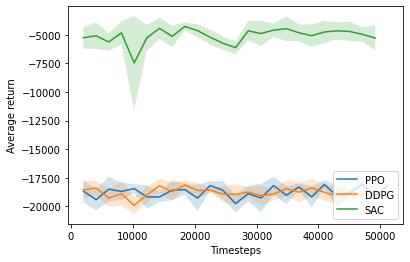

In [12]:
results = {'PPO': './logs/dam/ppo',
           'DDPG': './logs/dam/ddpg',
           'SAC': './logs/dam/sac'}
        
plot_results(results)